# COMP5329 - Deep Learning : Assignment 2

### Readme
How to run：
- You need to put the dataset into the folder 'Input' to ensure that the data and csv are read properly.
- First you need to run all the code in section 1, 2 to import the necessary packages,data and some functions to implement the model.
- In the next step I suggest you skip section 3.and 4. These sections are used to compare experiments and find the best model. If you need to check,run the following code, which will take you a lot of time, at least 3 hour or more, if you don't need to confirm please skip directly to the optimal model training and testing section(Section 5).
- In the last step you can run all the code in Section5 and you will get the same results and data as we did. (around 1 hour)

The following codes are all running through: 
- Hardware：CPU:Intel(R) Core(TM) i9-10850K CPU @ 3.60GHz   3.60 GHz
- Hardware: GUP:Chipset: NVIDIA GeForce RTX 2080 with 11GB GDDR6
- Software： the jupyter notebook.

## Section1 import packages

In [1]:
import re
import pandas as pd
from io import StringIO
from sklearn.metrics import  f1_score
import os
from tqdm import tqdm
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torchvision import transforms 
from torchvision.transforms import Compose
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt 
import torchvision.models as models
device = torch.device("cuda")
import sentencepiece
from transformers import BertTokenizer, BertModel

## Section2 Preprocessing data

In [2]:
data_path = 'Input/data'
FILENAME = 'Input/train.csv'
with open(FILENAME) as file:
  lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
  train_df = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

FILENAME = 'Input/test.csv'
with open(FILENAME) as file:
  lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
  test_df = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

In [3]:
transforms_imag=torchvision.transforms.Compose([torchvision.transforms.Resize([224,224]),
                                                torchvision.transforms.ToTensor(),
                                                transforms.RandomHorizontalFlip(p=0.5),
                                                transforms.RandomVerticalFlip(p=0.5),
                                                transforms.RandomRotation(30),
                                                torchvision.transforms.Normalize((0.464, 0.449, 0.421), (0.235, 0.228, 0.232))
                                               ])

In [4]:
len_list = []
for i in train_df['Caption']:
    len_list.append(len(i))
np.mean(len_list)

51.98279770636085

### 2.1 Get word embedding of Caption by pre-training model Bert

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained('bert-base-uncased').cuda()
def embedding(sentence):
    inputs = tokenizer.encode_plus(
        sentence,
        None,
        add_special_tokens=True,
        max_length=80,
        padding='max_length',
        return_token_type_ids=True,
        truncation=True
    )
    ids = torch.tensor(inputs['input_ids'], dtype=torch.long).unsqueeze(0).cuda()
    mask = torch.tensor(inputs['attention_mask'], dtype=torch.long).unsqueeze(0).cuda()
    token_type_ids = torch.tensor(inputs["token_type_ids"], dtype=torch.long).unsqueeze(0).cuda()
    bert_output = bert(ids, attention_mask = mask, token_type_ids = token_type_ids)  
    bert_output = bert_output.last_hidden_state.view(80, 768).cpu().detach().numpy()
    return bert_output

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
tqdm.pandas(desc='apply')
train_df['Caption'] = train_df['Caption'] .progress_apply(embedding)
test_df['Caption'] = test_df['Caption'] .progress_apply(embedding)

C:\Users\will\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
apply: 100%|█████████████████████████████████████████████████████████████████████| 10000/10000 [01:57<00:00, 84.80it/s]


### 2.2 Customize the MyDataset function and convert the labels to one-hot encoding and set up cross-validation

In [20]:
class MyDataset(Dataset):

    def __init__(self,input_root,label_df,transform,test = False):
      
        self.input_root=input_root
        self.input_files=os.listdir(input_root)
        self.label_df = label_df
        self.transforms = transform
        self.test = test

    def __len__(self):
        #get dataset size
        return len(self.label_df['ImageID'])
    def __getitem__(self, index):
        #get image according to index### 2.1 Get word embedding of Caption by pre-training model Bert
        id = self.label_df['ImageID'][index]
        input_img_path=os.path.join(self.input_root,id)
        input_img=Image.open(input_img_path)

        if self.transforms:
            #transforms
            input_img=self.transforms(input_img)

        bert_embedding = torch.tensor(self.label_df['Caption'][index])

        if self.test:

            return (input_img,id,bert_embedding)

        else:

            label_img=self.label_df['Labels'][index].split(" ")
            one_hot_label = np.zeros(20)
            for i in range(len(label_img)):
                one_hot_label += np.eye(20)[int(label_img[i])]

            return (input_img,one_hot_label,id,bert_embedding)

In [21]:
valid_size = 0.2
valid_dataset_1 = train_df.sample(frac=valid_size,random_state=None)
train_dataset_1 = train_df.drop(valid_dataset_1.index)
valid_size_2 = 0.25
valid_dataset_2 = train_dataset_1.sample(frac=valid_size_2,random_state=None)
train_dataset_2 = train_df.drop(valid_dataset_2.index)

train_dataset_1 = train_dataset_1.reset_index(drop=True)
valid_dataset_1 = valid_dataset_1.reset_index(drop=True)
train_dataset_2 = train_dataset_2.reset_index(drop=True)
valid_dataset_2 = valid_dataset_2.reset_index(drop=True)

In [22]:
training_set_1 = MyDataset(data_path, train_dataset_1, transforms_imag)
validation_set_1 = MyDataset(data_path, valid_dataset_1, transforms_imag)
training_set_2 = MyDataset(data_path, train_dataset_2, transforms_imag)
validation_set_2 = MyDataset(data_path, valid_dataset_2, transforms_imag)
test_dataset = MyDataset(data_path, test_df, transforms_imag,test=True)

train_loader_1 = torch.utils.data.DataLoader(training_set_1,batch_size=64, shuffle=True)
valid_loader_1 = torch.utils.data.DataLoader(validation_set_1,batch_size=64, shuffle=True)
train_loader_2 = torch.utils.data.DataLoader(training_set_2,batch_size=64, shuffle=True)
valid_loader_2 = torch.utils.data.DataLoader(validation_set_2,batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=64, shuffle=False)

In [23]:
def onehot_to_labels(labels):
    tag = []
    for i,label in enumerate(labels):
        if label == 1:
            tag.append(i)
    tag = " ".join(str(i) for i in tag)
    return tag


# 3.Train different models to get the best model

### 3.1 Resnext50 based models 

In [7]:
#Use the pre-trained resnext50_32x4d model and modify the fully connected layer
class Resnext50(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnext50_32x4d(pretrained=True)
        resnet.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features=resnet.fc.in_features, out_features=20)
        )
        self.base_model = resnet

    def forward(self, x):
        res_feat = self.base_model(x)
        return res_feat


In [15]:
class ChannelAtt(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAtt, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1   = nn.Conv2d(in_planes, in_planes // 16, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Conv2d(in_planes // 16, in_planes, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        inp = x
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        output = inp * (self.sigmoid(out))
        output = self.avg_pool(output)
        return output

In [62]:
#Define Resnet50, change the avgpool layer to attention layer, 
# and output 20 features from the fully connected layer
class Resnext50_att_1(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnext50_32x4d(pretrained=True)
        resnet.avgpool = nn.Sequential(
            ChannelAtt(in_planes = 2048)
        )
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=resnet.fc.in_features, out_features=20)
        )

        self.base_model = resnet

    def forward(self, x):

        x = self.base_model(x)

        return x

#### Training Resnext50 model

In [63]:
resnet = Resnext50().cuda()
resnet.train()
learning_rate = 1e-4
optimizer = torch.optim.AdamW(resnet.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()

epoch = 0
max_epoch_number = 5
loss = 1000
resnet50_loss = []
resnet50_loss_vl = []
resnet50_f1 = []
while True:
    resnet.train()
    batch_losses = []
    for imgs, targets,_,_ in tqdm(train_loader_1):
        imgs, targets = imgs.to(device), targets.to(device)

        optimizer.zero_grad()
        model_result = resnet(imgs)
        loss = criterion(model_result, targets.type(torch.float))
        batch_loss_value = loss.item()
        loss.backward()
        optimizer.step()
        
        batch_losses.append(batch_loss_value)

    loss_value = np.mean(batch_losses)

    resnet.eval()
    with torch.no_grad():
        vaild_result = []
        targets = []
        val_losses = []
        for imgs,target,id,_ in tqdm(valid_loader_1):

            imgs, target = imgs.to(device), target.to(device)

            valid_batch_result = resnet(imgs)
            vaild_result.extend(valid_batch_result.cpu().numpy())

            loss = criterion(valid_batch_result, target.type(torch.float))
            targets.extend(target.cpu().numpy())
            batch_loss_value = loss.item()
            val_losses.append(batch_loss_value)
    valid_loss = np.mean(val_losses)
    vaild_result = np.array(np.array(vaild_result) > 0, dtype=float)

    f1 = f1_score(y_true=targets, y_pred=vaild_result, average='samples')
    resnet50_loss.append(loss_value)
    resnet50_loss_vl.append(valid_loss)
    resnet50_f1.append(f1)

    print("epoch:{:2d}  train: loss:{:.8f} valid: loss:{:.8f}  valid f1:{:3f}".format(epoch,loss_value,valid_loss,f1))
    epoch += 1
    if max_epoch_number < epoch:
        break

  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch: 0  train: loss:0.13287023 valid: loss:0.09586155  valid f1:0.780089


  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch: 1  train: loss:0.08886029 valid: loss:0.09110178  valid f1:0.785910


  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch: 2  train: loss:0.07890862 valid: loss:0.08966113  valid f1:0.804622


  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch: 3  train: loss:0.07054646 valid: loss:0.09036982  valid f1:0.797613


  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch: 4  train: loss:0.06454304 valid: loss:0.09052069  valid f1:0.807986


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:52<00:00,  1.79it/s]

epoch: 5  train: loss:0.05815088 valid: loss:0.09293178  valid f1:0.799361


#### Training Resnext50 with attention layer model

In [64]:
resnet = Resnext50_att_1().cuda()
resnet.train()
learning_rate = 1e-4
optimizer = torch.optim.AdamW(resnet.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()

epoch = 0
max_epoch_number = 5
loss = 1000
resnet50_att_loss = []
resnet50_att_loss_vl = []
resnet50_att_f1 = []
while True:
    resnet.train()
    batch_losses = []
    for imgs, targets,_,_ in tqdm(train_loader_1):
        imgs, targets = imgs.to(device), targets.to(device)

        optimizer.zero_grad()
        model_result = resnet(imgs)
        loss = criterion(model_result, targets.type(torch.float))
        batch_loss_value = loss.item()
        loss.backward()
        optimizer.step()
        
        batch_losses.append(batch_loss_value)

    loss_value = np.mean(batch_losses)

    resnet.eval()
    with torch.no_grad():
        vaild_result = []
        targets = []
        val_losses = []
        for imgs,target,id,_ in tqdm(valid_loader_1):

            imgs, target = imgs.to(device), target.to(device)

            valid_batch_result = resnet(imgs)
            vaild_result.extend(valid_batch_result.cpu().numpy())

            loss = criterion(valid_batch_result, target.type(torch.float))
            targets.extend(target.cpu().numpy())
            batch_loss_value = loss.item()
            val_losses.append(batch_loss_value)
    valid_loss = np.mean(val_losses)
    vaild_result = np.array(np.array(vaild_result) > 0, dtype=float)

    f1 = f1_score(y_true=targets, y_pred=vaild_result, average='samples')
    resnet50_att_loss.append(loss_value)
    resnet50_att_loss_vl.append(valid_loss)
    resnet50_att_f1.append(f1)

    print("epoch:{:2d}  train: loss:{:.8f} valid: loss:{:.8f}  valid f1:{:3f}".format(epoch,loss_value,valid_loss,f1))
    epoch += 1
    if max_epoch_number < epoch:
        break

  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch: 0  train: loss:0.14204308 valid: loss:0.09825142  valid f1:0.755838


  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch: 1  train: loss:0.09022124 valid: loss:0.09175410  valid f1:0.788865


  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch: 2  train: loss:0.07990404 valid: loss:0.09213481  valid f1:0.793054


  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch: 3  train: loss:0.07218300 valid: loss:0.08951595  valid f1:0.804603


  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch: 4  train: loss:0.06549798 valid: loss:0.09205923  valid f1:0.804002


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:53<00:00,  1.75it/s]

epoch: 5  train: loss:0.05919203 valid: loss:0.09244867  valid f1:0.810263


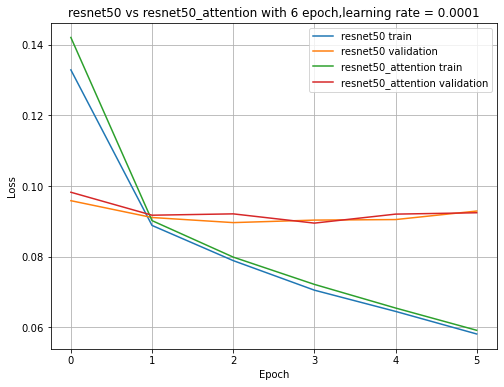

In [65]:
plt.figure(figsize=(8,6))
plt.plot(resnet50_loss)
plt.plot(resnet50_loss_vl)
plt.plot(resnet50_att_loss)
plt.plot(resnet50_att_loss_vl)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('resnet50 vs resnet50_attention with 6 epoch,learning rate = 0.0001')
plt.legend(['resnet50 train','resnet50 validation','resnet50_attention train','resnet50_attention validation'],loc='best')
plt.grid()

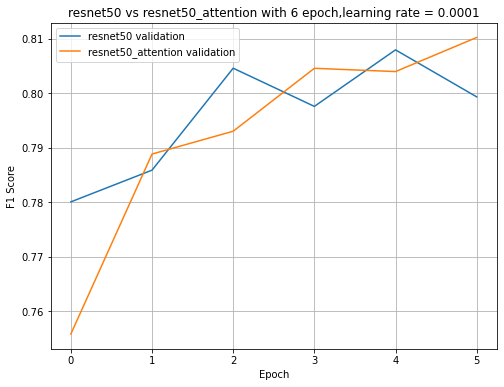

In [66]:
plt.figure(figsize=(8,6))
plt.plot(resnet50_f1)
plt.plot(resnet50_att_f1)
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('resnet50 vs resnet50_attention with 6 epoch,learning rate = 0.0001')
plt.legend(['resnet50 validation','resnet50_attention validation'],loc='best')
plt.grid()

### 3.2 ResNet_Attention layer and BiLSTM_Attention layer concatenation

In [67]:
class Resnext50_att_2(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnext50_32x4d(pretrained=True)
        resnet.avgpool = nn.Sequential(
            ChannelAtt(in_planes = 2048)
        )
        resnet.fc = nn.Sequential()

        self.base_model = resnet

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))


    def forward(self, x):

        x = self.base_model(x)

        x = x.reshape(x.size(0), -1)

        return x

In [68]:
class BiLSTM_Attention_2(nn.Module):  
    
    def __init__(self,embedding_dim, hidden_dim, n_layers):
        super(BiLSTM_Attention_2, self).__init__()
        
        self.base_model = Resnext50_att_2()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers       
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, batch_first =True,bidirectional=True, dropout=0.5)
        self.fc = nn.Linear(hidden_dim * 2 + 2048, 20)
        nn.init.kaiming_normal_(self.fc.weight)
        self.dropout = nn.Dropout(0.5)
        
     #x,query：[batch, seq_len, hidden_dim*2]
    def attention_net(self, x, query, mask=None):      #Soft attention mechanism（key=value=x）
    
        d_k = query.size(-1)                           #d_k is the dimension of query
        scores = torch.matmul(query, x.transpose(1, 2)) / np.sqrt(d_k)  #Scoring mechanism  scores:[batch, seq_len, seq_len]
        
        p_attn = F.softmax(scores, dim = -1)           #Normalize the score for the last dimension
        context = torch.matmul(p_attn, x).sum(1)       #Sum the weighted x，[batch, seq_len, hidden_dim*2]->[batch, hidden_dim*2]
        return context, p_attn             
    
    def forward(self, imgs,x):     
        res_feat = self.base_model(imgs)             
        output, (final_hidden_state, final_cell_state) = self.rnn(x)  #[batch, seq_len, hidden_dim*2]
        query = self.dropout(output)
        attn_output, attention = self.attention_net(output, query) 
        
        all_faet = torch.cat((attn_output,res_feat),1)    
        logit = self.fc(all_faet)
        
        return logit

In [69]:
biLSTM_Attention_2 = BiLSTM_Attention_2(768, hidden_dim=256, n_layers=2).cuda()
learning_rate = 0.0001
optimizer = optim.AdamW(biLSTM_Attention_2.parameters(), lr=learning_rate,betas=(0.8,0.999))
criterion = nn.BCEWithLogitsLoss()

In [70]:
epoch = 0
max_epoch_number = 5
iteration = 0
test_freq = 1
loss = 1000
while True:
    biLSTM_Attention_2.train()
    batch_losses = []
    for imgs, targets,_, bert_output in tqdm(train_loader_1):
        imgs, targets= imgs.to(device), targets.to(device)
        bert_output = bert_output.to(device)

        optimizer.zero_grad()
        model_result = biLSTM_Attention_2(imgs,bert_output)
        loss = criterion(model_result, targets.type(torch.float))
        batch_loss_value = loss.item()
        loss.backward()
        optimizer.step()
        
        batch_losses.append(batch_loss_value)

    loss_value = np.mean(batch_losses)
    if loss > loss_value:
        loss = loss_value
        torch.save(biLSTM_Attention_2.state_dict(),'biLSTM_Attention2.pth')

    biLSTM_Attention.eval()
    with torch.no_grad():
        vaild_result = []
        targets_list = []
        val_losses = []
        for imgs,targets,_,bert_output in tqdm(valid_loader_1):
            bert_output = bert_output.to(device)
            imgs, targets = imgs.to(device), targets.to(device)

            valid_batch_result = biLSTM_Attention_2(imgs,bert_output)
            vaild_result.extend(valid_batch_result.cpu().numpy())

            loss = criterion(valid_batch_result, targets.type(torch.float))
            targets_list.extend(targets.cpu().numpy())
            batch_loss_value = loss.item()
            val_losses.append(batch_loss_value)
    valid_loss = np.mean(val_losses)
    vaild_result = np.array(np.array(vaild_result) > 0, dtype=float)
    f1 = f1_score(y_true=targets_list, y_pred=vaild_result, average='samples')
    print("epoch:{:2d}  train: loss:{:.8f} valid: loss:{:.8f}  valid f1:{:3f}".format(epoch,loss_value,valid_loss,f1))
    epoch += 1
    if max_epoch_number < epoch:
        break

  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch: 0  train: loss:0.11106924 valid: loss:0.08511532  valid f1:0.816463


  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch: 1  train: loss:0.07368415 valid: loss:0.08162322  valid f1:0.837156


  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch: 2  train: loss:0.06504449 valid: loss:0.08058005  valid f1:0.846700


  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch: 3  train: loss:0.05779821 valid: loss:0.08052479  valid f1:0.839040


  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch: 4  train: loss:0.05042114 valid: loss:0.08535071  valid f1:0.843447


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:56<00:00,  1.67it/s]

epoch: 5  train: loss:0.04397515 valid: loss:0.08654782  valid f1:0.845831


In [27]:
biLSTM_Attention_2_F1 = [0.816463,0.837156,0.846700,0.839040,0.843447,0.845831]

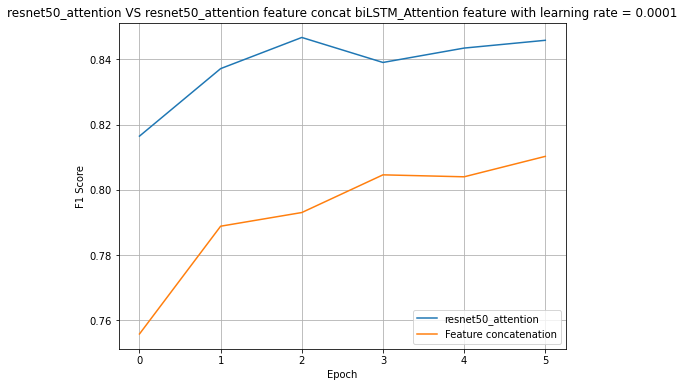

In [87]:
plt.figure(figsize=(8,6))
plt.plot(biLSTM_Attention_2_F1)
plt.plot(resnet50_att_f1)
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('resnet50_attention VS resnet50_attention feature concat biLSTM_Attention feature with learning rate = 0.0001')
plt.legend(['resnet50_attention','Feature concatenation'],loc='best')
plt.grid()

### 3.3 ResNet_Attention combine with BiLSTM_Attention

In [12]:
class BiLSTM_Attention_3(nn.Module):  
    
    def __init__(self,embedding_dim, hidden_dim, n_layers):
        super(BiLSTM_Attention_3, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers       
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, batch_first =True,bidirectional=True, dropout=0.3)
        self.fc = nn.Linear(hidden_dim * 2, 20)  
        nn.init.kaiming_normal_(self.fc.weight)
        self.dropout = nn.Dropout(0.5)
        
     #x,query：[batch, seq_len, hidden_dim*2]
    def attention_net(self, x, query, mask=None):     
    
        d_k = query.size(-1)                                           
        scores = torch.matmul(query, x.transpose(1, 2)) / np.sqrt(d_k) 
        
        p_attn = F.softmax(scores, dim = -1)                           
        context = torch.matmul(p_attn, x).sum(1)       
        return context, p_attn             
       
    def forward(self,x):     

        output, (final_hidden_state, final_cell_state) = self.rnn(x)               
        query = self.dropout(output)
        attn_output, attention = self.attention_net(output, query)     
        logit = self.fc(attn_output)
        
        return logit

In [16]:
class Resnext50_att_3(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnext50_32x4d(pretrained=True)
        resnet.avgpool = nn.Sequential(
            ChannelAtt(in_planes = 2048)
        )
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=resnet.fc.in_features, out_features=20)
        )

        self.base_model = resnet

    def forward(self, x):

        x = self.base_model(x)

        return x

In [17]:
lstm_bert = BiLSTM_Attention_3(768, hidden_dim=128, n_layers=2).cuda()
resnet_50 = Resnext50_att_3().cuda()

In [18]:
learning_rate = 0.0001
optimizer_L = optim.AdamW(lstm_bert.parameters(), lr=learning_rate,betas=(0.8,0.999))
optimizer_R = optim.AdamW(resnet_50.parameters(), lr=learning_rate,betas=(0.8,0.999))
criterion_L = nn.BCEWithLogitsLoss()
criterion_R = nn.BCEWithLogitsLoss()

In [25]:
epoch = 0
max_epoch_number = 5

loss0 = 1000
loss1 = 1000

f1_list = []
while True:
    lstm_bert.train()
    resnet_50.train()
    lstm_losses = []
    resnet_losses = []
    for imgs, targets,_, bert_output in tqdm(train_loader_1):
        imgs, targets= imgs.to(device), targets.to(device)
        bert_output = bert_output.to(device)

        optimizer_L.zero_grad()
        lstm_result = lstm_bert(bert_output)
        loss = criterion_L(lstm_result, targets.type(torch.float))
        batch_loss_lstm = loss.item()
        loss.backward()
        optimizer_L.step()
        lstm_losses.append(batch_loss_lstm)

        optimizer_R.zero_grad()
        resnet_result = resnet_50(imgs)
        loss = criterion_L(resnet_result, targets.type(torch.float))
        batch_loss_resnet = loss.item()
        loss.backward()
        optimizer_R.step()
        resnet_losses.append(batch_loss_resnet)

    loss_lstm= np.mean(lstm_losses)
    loss_resnet= np.mean(resnet_losses)
    if loss0 > loss_lstm:
        loss0 = loss_lstm
        torch.save(lstm_bert.state_dict(),'lstm_at.pth')

    if loss1 > loss_resnet:
        loss1 = loss_resnet
        torch.save(resnet_50.state_dict(),'resnet_50.pth')

    resnet_50.eval()
    lstm_bert.eval() 
    with torch.no_grad():
        vaild_result = []
        targets_list = []
        val_losses = []
        for imgs,targets,_,bert_output in tqdm(valid_loader_1):
            bert_output = bert_output.to(device)
            imgs, targets = imgs.to(device), targets.to(device)

            valid_lstm_result = lstm_bert(bert_output)
            valid_resnet_result = resnet_50(imgs)
            result = (valid_lstm_result + valid_resnet_result) / 2
            vaild_result.extend(result.cpu().numpy())
            targets_list.extend(targets.cpu().numpy())

    vaild_result = np.array(np.array(vaild_result) > 0, dtype=float)

    f1 = f1_score(y_true=targets_list, y_pred=vaild_result, average='samples')
    f1_list.append(f1)
    print("epoch:{:2d}  lstm_train: loss:{:.8f} resnet_train: loss:{:.8f}  valid f1:{:3f}".format(epoch,loss_lstm,loss_resnet,f1))
    epoch += 1
    if max_epoch_number < epoch:
        break


  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch: 0  lstm_train: loss:0.08812875 resnet_train: loss:0.06598204  valid f1:0.838559


  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch: 1  lstm_train: loss:0.08549907 resnet_train: loss:0.05995794  valid f1:0.840356


  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch: 2  lstm_train: loss:0.08329943 resnet_train: loss:0.05352304  valid f1:0.846381


  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch: 3  lstm_train: loss:0.08157548 resnet_train: loss:0.04728140  valid f1:0.842950


  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch: 4  lstm_train: loss:0.07967075 resnet_train: loss:0.04197129  valid f1:0.849292


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:46<00:00,  2.00it/s]

epoch: 5  lstm_train: loss:0.07821699 resnet_train: loss:0.03764281  valid f1:0.851828


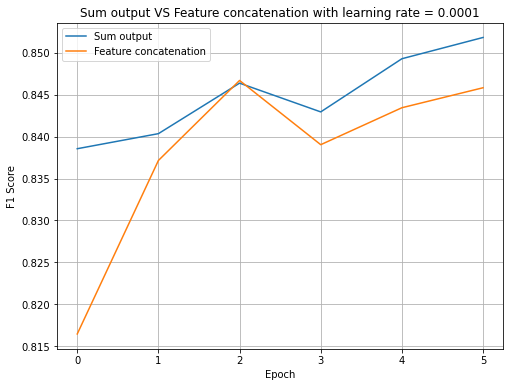

In [30]:
plt.figure(figsize=(8,6))
plt.plot(f1_list)
plt.plot(biLSTM_Attention_2_F1)
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Sum output VS Feature concatenation with learning rate = 0.0001')
plt.legend(['Sum output','Feature concatenation'],loc='best')
plt.grid()

## Section4. BestModel finetune

In [38]:
def train_re_ls(lstm_bert,resnet_50,epoch = 5,learning_rate = 0.0001):
    
    learning_rate = learning_rate
    optimizer_L = optim.AdamW(lstm_bert.parameters(), lr=learning_rate,betas=(0.8,0.999))
    optimizer_R = optim.AdamW(resnet_50.parameters(), lr=learning_rate,betas=(0.8,0.999))
    criterion_L = nn.BCEWithLogitsLoss()
    criterion_R = nn.BCEWithLogitsLoss()

    max_epoch_number = epoch

    loss0 = 1000
    loss1 = 1000

    f1_list = []
    for i in range(max_epoch_number):
        lstm_bert.train()
        resnet_50.train()
        lstm_losses = []
        resnet_losses = []
        for imgs, targets,_, bert_output in tqdm(train_loader_1):
            imgs, targets= imgs.to(device), targets.to(device)
            bert_output = bert_output.to(device)

            optimizer_L.zero_grad()
            lstm_result = lstm_bert(bert_output)
            loss = criterion_L(lstm_result, targets.type(torch.float))
            batch_loss_lstm = loss.item()
            loss.backward()
            optimizer_L.step()
            lstm_losses.append(batch_loss_lstm)

            optimizer_R.zero_grad()
            resnet_result = resnet_50(imgs)
            loss = criterion_L(resnet_result, targets.type(torch.float))
            batch_loss_resnet = loss.item()
            loss.backward()
            optimizer_R.step()
            resnet_losses.append(batch_loss_resnet)

        loss_lstm= np.mean(lstm_losses)
        loss_resnet= np.mean(resnet_losses)
        if loss0 > loss_lstm:
            loss0 = loss_lstm
            torch.save(lstm_bert.state_dict(),'lstm_at.pth')

        if loss1 > loss_resnet:
            loss1 = loss_resnet
            torch.save(resnet_50.state_dict(),'resnet_50.pth')

        resnet_50.eval()
        lstm_bert.eval() 
        with torch.no_grad():
            vaild_result = []
            targets_list = []
            val_losses = []
            for imgs,targets,_,bert_output in tqdm(valid_loader_1):
                bert_output = bert_output.to(device)
                imgs, targets = imgs.to(device), targets.to(device)

                valid_lstm_result = lstm_bert(bert_output)
                valid_resnet_result = resnet_50(imgs)
                result = (valid_lstm_result + valid_resnet_result) / 2
                vaild_result.extend(result.cpu().numpy())
                targets_list.extend(targets.cpu().numpy())

        vaild_result = np.array(np.array(vaild_result) > 0, dtype=float)

        f1 = f1_score(y_true=targets_list, y_pred=vaild_result, average='samples')
        f1_list.append(f1)
        print("epoch:{:2d}  lstm_train: loss:{:.8f} resnet_train: loss:{:.8f}  valid f1:{:3f}".format(i+1,loss_lstm,loss_resnet,f1))

    return f1_list

In [39]:
lstm_bert = BiLSTM_Attention_3(768, hidden_dim=64, n_layers=2).cuda()
resnet_50 = Resnext50_att_3().cuda()
f1_64_2 = train_re_ls(lstm_bert,resnet_50,epoch = 5,learning_rate = 0.0001)

  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch: 1  lstm_train: loss:0.23655070 resnet_train: loss:0.14244659  valid f1:0.770241


  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch: 2  lstm_train: loss:0.11742349 resnet_train: loss:0.09058476  valid f1:0.802221


  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch: 3  lstm_train: loss:0.10467958 resnet_train: loss:0.08035785  valid f1:0.825147


  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch: 4  lstm_train: loss:0.09832034 resnet_train: loss:0.07292645  valid f1:0.831591


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:46<00:00,  2.01it/s]

epoch: 5  lstm_train: loss:0.09403775 resnet_train: loss:0.06602372  valid f1:0.829204


In [41]:
lstm_bert = BiLSTM_Attention_3(768, hidden_dim= 64, n_layers=4).cuda()
resnet_50 = Resnext50_att_3().cuda()
f1_64_4 = train_re_ls(lstm_bert,resnet_50,epoch = 5,learning_rate = 0.0001)

  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch: 1  lstm_train: loss:0.19654170 resnet_train: loss:0.14025595  valid f1:0.777538


  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch: 2  lstm_train: loss:0.10717124 resnet_train: loss:0.08986323  valid f1:0.815095


  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch: 3  lstm_train: loss:0.09809226 resnet_train: loss:0.08005748  valid f1:0.828286


  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch: 4  lstm_train: loss:0.09309535 resnet_train: loss:0.07219197  valid f1:0.842922


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:46<00:00,  2.03it/s]

epoch: 5  lstm_train: loss:0.08981503 resnet_train: loss:0.06572720  valid f1:0.847159


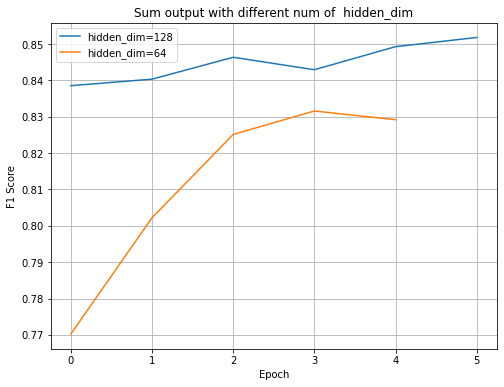

In [42]:
plt.figure(figsize=(8,6))
plt.plot(f1_list)
plt.plot(f1_64_2)
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Sum output with different num of  hidden_dim')
plt.legend(['hidden_dim=128','hidden_dim=64'],loc='best')
plt.grid()

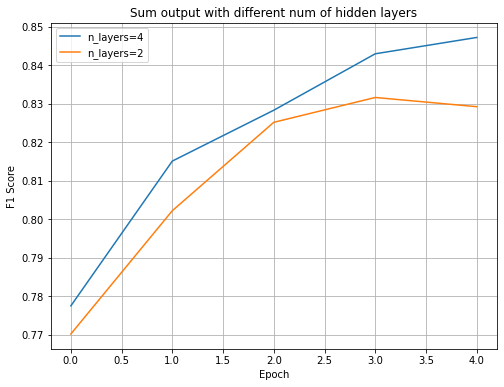

In [43]:
plt.figure(figsize=(8,6))
plt.plot(f1_64_4)
plt.plot(f1_64_2)
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Sum output with different num of hidden layers')
plt.legend(['n_layers=4','n_layers=2'],loc='best')
plt.grid()

## Section5 Train BestModel by Cross-validation and output

- Finally, we choose 128 nodes and 2 hidden layers in training model to avoid the total size of model over than 100M, which is the best model structure we have. There are a total of 24865128 parameters in our model, which is approximately equal to 94.8M. It should be noted that the highest F1-score obtained by our model during training is 0.91, but the result on Kaggle is only 0.879.

In [44]:
class BiLSTM_Attention_3(nn.Module):  
    
    def __init__(self,embedding_dim, hidden_dim, n_layers):
        super(BiLSTM_Attention_3, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers       
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, batch_first =True,bidirectional=True, dropout=0.3)
        self.fc = nn.Linear(hidden_dim * 2, 20)  
        nn.init.kaiming_normal_(self.fc.weight)
        self.dropout = nn.Dropout(0.5)
        
     #x,query：[batch, seq_len, hidden_dim*2]
    def attention_net(self, x, query, mask=None):      #Soft attention mechanism（key=value=x）
    
        d_k = query.size(-1)                           #d_k is the dimension of query
        scores = torch.matmul(query, x.transpose(1, 2)) / np.sqrt(d_k)  #Scoring mechanism  scores:[batch, seq_len, seq_len]
        
        p_attn = F.softmax(scores, dim = -1)           #Normalize the score for the last dimension
        context = torch.matmul(p_attn, x).sum(1)       #Sum the weighted x，[batch, seq_len, hidden_dim*2]->[batch, hidden_dim*2]
        return context, p_attn             
       
    def forward(self,x):     

        output, (final_hidden_state, final_cell_state) = self.rnn(x)               
        query = self.dropout(output)
        attn_output, attention = self.attention_net(output, query)     
        logit = self.fc(attn_output)
        
        return logit

In [45]:
class ChannelAtt(nn.Module):
    #Define the Attention layer class
    
    def __init__(self, in_planes, ratio=16):
        super(ChannelAtt, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1   = nn.Conv2d(in_planes, in_planes // 16, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Conv2d(in_planes // 16, in_planes, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        inp = x
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        output = inp * (self.sigmoid(out))
        output = self.avg_pool(output)
        
        return output

In [46]:
class Resnext50_att_3(nn.Module):
    #Define Resnet50, change the avgpool layer to attention layer, 
    # and output 20 features from the fully connected layer
    
    def __init__(self):
        super().__init__()
        resnet = models.resnext50_32x4d(pretrained=True)
        resnet.avgpool = nn.Sequential(
            ChannelAtt(in_planes = 2048)
        )
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=resnet.fc.in_features, out_features=20)
        )

        self.base_model = resnet

    def forward(self, x):

        x = self.base_model(x)

        return x

In [47]:
lstm_bert = BiLSTM_Attention_3(768, hidden_dim=128, n_layers=2).cuda()
resnet_50 = Resnext50_att_3().cuda()

In [50]:
num_lstm = sum(p.numel() for p in lstm_bert.parameters())
num_resnet_50 = sum(p.numel() for p in resnet_50.parameters())
total = num_lstm + num_resnet_50
print('The total parameter of the model is {}, about 94.8M'.format(total))

The total parameter of the model is 24865128, about 94.8M


In [ ]:
learning_rate = 0.0001
optimizer_L = optim.AdamW(lstm_bert.parameters(), lr=learning_rate,betas=(0.8,0.999))
optimizer_R = optim.AdamW(resnet_50.parameters(), lr=learning_rate,betas=(0.8,0.999))
criterion_L = nn.BCEWithLogitsLoss()
criterion_R = nn.BCEWithLogitsLoss()

In [47]:
epoch = 0
max_epoch_number = 5

loss0 = 1000
loss1 = 1000
while True:
    lstm_bert.train()
    resnet_50.train()
    lstm_losses = []
    resnet_losses = []
    for imgs, targets,_, bert_output in tqdm(train_loader_1):
        imgs, targets= imgs.to(device), targets.to(device)
        bert_output = bert_output.to(device)

        optimizer_L.zero_grad()
        lstm_result = lstm_bert(bert_output)
        loss = criterion_L(lstm_result, targets.type(torch.float))
        batch_loss_lstm = loss.item()
        loss.backward()
        optimizer_L.step()
        lstm_losses.append(batch_loss_lstm)

        optimizer_R.zero_grad()
        resnet_result = resnet_50(imgs)
        loss = criterion_L(resnet_result, targets.type(torch.float))
        batch_loss_resnet = loss.item()
        loss.backward()
        optimizer_R.step()
        resnet_losses.append(batch_loss_resnet)

    loss_lstm= np.mean(lstm_losses)
    loss_resnet= np.mean(resnet_losses)
    if loss0 > loss_lstm:
      loss0 = loss_lstm
      torch.save(lstm_bert.state_dict(),'lstm_at.pth')

    if loss1 > loss_resnet:
      loss1 = loss_resnet
      torch.save(resnet_50.state_dict(),'resnet_50.pth')

    resnet_50.eval()
    lstm_bert.eval() 
    with torch.no_grad():
        vaild_result = []
        targets_list = []
        val_losses = []
        for imgs,targets,_,bert_output in tqdm(valid_loader_1):
            bert_output = bert_output.to(device)
            imgs, targets = imgs.to(device), targets.to(device)

            valid_lstm_result = lstm_bert(bert_output)
            valid_resnet_result = resnet_50(imgs)
            result = (valid_lstm_result + valid_resnet_result) / 2
            vaild_result.extend(result.cpu().numpy())
            targets_list.extend(targets.cpu().numpy())

    vaild_result = np.array(np.array(vaild_result) > 0, dtype=float)

    f1 = f1_score(y_true=targets_list, y_pred=vaild_result, average='samples')
    print("epoch:{:2d}  lstm_train: loss:{:.8f} resnet_train: loss:{:.8f}  valid f1:{:3f}".format(epoch,loss_lstm,loss_resnet,f1))

    lstm_bert.train()
    resnet_50.train()
    lstm_losses = []
    resnet_losses = []
    for imgs, targets,_, bert_output in tqdm(train_loader_2):
        imgs, targets= imgs.to(device), targets.to(device)
        bert_output = bert_output.to(device)

        optimizer_L.zero_grad()
        lstm_result = lstm_bert(bert_output)
        loss = criterion_L(lstm_result, targets.type(torch.float))
        batch_loss_lstm = loss.item()
        loss.backward()
        optimizer_L.step()
        lstm_losses.append(batch_loss_lstm)

        optimizer_R.zero_grad()
        resnet_result = resnet_50(imgs)
        loss = criterion_L(resnet_result, targets.type(torch.float))
        batch_loss_resnet = loss.item()
        loss.backward()
        optimizer_R.step()
        resnet_losses.append(batch_loss_resnet)

    loss_lstm= np.mean(lstm_losses)
    loss_resnet= np.mean(resnet_losses)
    if loss0 > loss_lstm:
      loss0 = loss_lstm
      torch.save(lstm_bert.state_dict(),'lstm_at.pth')

    if loss1 > loss_resnet:
      loss1 = loss_resnet
      torch.save(resnet_50.state_dict(),'resnet_18.pth')

    resnet_50.eval()
    lstm_bert.eval() 
    with torch.no_grad():
        vaild_result = []
        targets_list = []
        val_losses = []
        for imgs,targets,_,bert_output in tqdm(valid_loader_2):
            bert_output = bert_output.to(device)
            imgs, targets = imgs.to(device), targets.to(device)

            valid_lstm_result = lstm_bert(bert_output)
            valid_resnet_result = resnet_50(imgs)

            result = (valid_lstm_result + valid_resnet_result) / 2
            vaild_result.extend(result.cpu().numpy())
            targets_list.extend(targets.cpu().numpy())

    vaild_result = np.array(np.array(vaild_result) > 0, dtype=float)

    f1 = f1_score(y_true=targets_list, y_pred=vaild_result, average='samples')
    print("epoch:{:2d}  lstm_train: loss:{:.8f} resnet_train: loss:{:.8f}  valid f1:{:3f}".format(epoch,loss_lstm,loss_resnet,f1))

    epoch += 1
    if max_epoch_number < epoch:
        break

  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch: 1  lstm_train: loss:0.06830091 resnet_train: loss:0.07834734  valid f1:0.883744


  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch: 1  lstm_train: loss:0.06577180 resnet_train: loss:0.07602072  valid f1:0.886421


  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch: 2  lstm_train: loss:0.06388053 resnet_train: loss:0.07399175  valid f1:0.888221


  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch: 2  lstm_train: loss:0.06111810 resnet_train: loss:0.07125469  valid f1:0.889637


  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch: 3  lstm_train: loss:0.05900887 resnet_train: loss:0.06934282  valid f1:0.892617


  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch: 3  lstm_train: loss:0.05593931 resnet_train: loss:0.06761635  valid f1:0.896062


  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch: 4  lstm_train: loss:0.05408040 resnet_train: loss:0.06559736  valid f1:0.901650


  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch: 4  lstm_train: loss:0.05088188 resnet_train: loss:0.06367471  valid f1:0.905839


  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

epoch: 5  lstm_train: loss:0.04916294 resnet_train: loss:0.06187785  valid f1:0.912777


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:39<00:00,  2.37it/s]

epoch: 5  lstm_train: loss:0.04535325 resnet_train: loss:0.06005000  valid f1:0.915137


In [49]:
resnet_50.eval()
lstm_bert.eval() 

with torch.no_grad():
    test_result = []
    iD = []
    for imgs,id,bert_output in tqdm(test_loader):
        bert_output = bert_output.to(device)
        imgs= imgs.to(device)

        valid_lstm_result = lstm_bert(bert_output)
        valid_resnet_result = resnet_50(imgs)
        result = torch.sigmoid(valid_lstm_result + valid_resnet_result)
        test_result.extend(result.cpu().numpy())
        iD.extend(id)

test_result = np.array(np.array(test_result) > 0.5, dtype=float)
labels = [onehot_to_labels(i) for i in test_result]

result = {}
for i,id_ in enumerate(iD):
    result[id_] = labels[i]
    
dataframe = pd.DataFrame({'ImageID':iD,'Labels':labels})
print(dataframe)
dataframe.to_csv(r"Output/test_result.csv",index=False)
dataframe.to_csv(r"Output/test_result.txt",index=False)

100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [01:05<00:00,  2.39it/s]


        ImageID Labels
0     30000.jpg      1
1     30001.jpg      1
2     30002.jpg      1
3     30003.jpg      1
4     30004.jpg      1
...         ...    ...
9995  39995.jpg      1
9996  39996.jpg    3 4
9997  39997.jpg      1
9998  39998.jpg      1
9999  39999.jpg      1

[10000 rows x 2 columns]
